
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Sommaire
        </h1>
    </div>
</div>

- **[Presentation](#da)**

- **[Importation et description des données](#im)**

- **[ évolution du nombre de questions par année](#ev)**

- **[Analyse des tags](#an)**

- **[remove html tag and escaping code sample in questions](#re)**

- **[Analyse des sequences de mots](#se)**

- **[Reconnaissance d'entité nommée](#rec)**

- **[Text cleaning](#txt)**

<a name='da'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Presentation
        </h1>
    </div>
</div>


**objectif** :
- Développer un algorithme de Machine Learning destiné à assigner automatiquement plusieurs tags pertinents à une question posée sur le célébre site Stack overflow.
- Ce programme s'adresse principalement aux nouveaux utilisateurs, afin de leur suggérer quelques tags relatifs à la question qu'ils souhaitent poser.


**les données** : 
- Les données ont été captées via l'outil d’export de données stackexchange explorer, qui recense un grand nombre de données authentiques de la plateforme d’entraide.
- Elles portent sur la période 2011 / 2022 et uniquement sur les posts "de qualité" ayant au minimum 1 réponse, 5 commentaires, 20 vues et un score supérieur à 5.


**requete effectuer**

<code>DECLARE @start_date DATE
DECLARE @end_date DATE
SET @start_date = '2012-03-22'
SET @end_date = DATEADD(m , 12 , @start_date)

select
    p.Id,
    p.CreationDate,
    p.Title,
    p.Body,
    p.Tags,
    p.ViewCount,
    p.CommentCount,
    p.AnswerCount,
    p.Score,      
    sum(case when VoteTypeId = 2 then 1 else 0 end) as [up] ,
    sum(case when VoteTypeId = 3 then 1 else 0 end) as [down]
                                         
from Votes v join Posts p on v.PostId = p.Id
LEFT JOIN PostTypes as t ON p.PostTypeId = t.id
group by 
    p.Id, 
    p.CreationDate,
    p.Title,
    p.Body,
    p.Tags,
    p.ViewCount,
    p.CommentCount,
    p.AnswerCount,
    p.Score,
    v.VoteTypeId,
    t.Name 
HAVING v.VoteTypeId in (2,3)
AND p.CreationDate between @start_date and @end_date
AND t.Name = 'Question'
AND p.ViewCount > 20
AND p.CommentCount > 5
AND p.AnswerCount > 1
AND p.Score > 5
AND len(p.Tags) > 0
ORDER BY [up] desc
</code>
Lancement de la requete par annees(2011 - 2022), recuperation des fichiers et merge.

Dans ce Notebook, nous allons traiter la partie data cleaning et exploration des données.
D autre notebook traiterons ensuite les approches supervisées et non supervisées pour traiter la création de Tags à partir des données textuelles.

In [18]:
# Import Python libraries
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import unicodedata
from bs4 import BeautifulSoup
from ast import literal_eval
# from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer

<a name='im'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
           Importation et description des données
        </h1>
    </div>
</div>

In [19]:
path = 'stackoverflow/'
columns = ['Id','CreationDate','Title','Body','Tags','ViewCount','CommentCount','AnswerCount','Score','up','down']
data = pd.DataFrame(columns=columns)

In [20]:
for file in os.listdir(path):
    if("QueryResults" in file):
        print('concat file {}'.format(file))
        temp = pd.read_csv(path+file)
        data = pd.concat([data,temp],
                         axis=0,
                         ignore_index=True)     
data.to_csv('stackoverFlow2011_2021.csv')        

concat file QueryResults_2011.csv
concat file QueryResults_2012.csv
concat file QueryResults_2013.csv
concat file QueryResults_2014.csv
concat file QueryResults_2015.csv
concat file QueryResults_2016.csv
concat file QueryResults_2017.csv
concat file QueryResults_2018.csv
concat file QueryResults_2019.csv
concat file QueryResults_2020.csv
concat file QueryResults_2021.csv


In [21]:
# data=pd.read_csv('stackoverFlow2011_2021.csv')
# data.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
data.shape

(116569, 11)

In [23]:
data.head(1)

,Id,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score,up,down
0,5767325,2011-04-23 22:17:18,How can I remove a specific item from an array?,"<p>I have an array of numbers and I'm using the <code>.push()</code> method to add elements to it.</p>\n\n<p>Is there a simple way to remove a specific element from an array?</p>\n\n<p>I'm looking for the equivalent of something like:</p>\n\n<pre class=""lang-js prettyprint-override""><code>array.remove(number);\n</code></pre>\n\n<p>I have to use <em>core</em> JavaScript. Frameworks are not allowed.</p>\n",<javascript><arrays>,9623441,9,127,10385,10404,0


In [24]:
data.loc[:,~(data.columns.isin(['Body']))].describe()

,Id,CreationDate,Title,Tags,ViewCount,CommentCount,AnswerCount,Score,up,down
count,116569,116569,116569,116569,116569,116569,116569,116569,101778,101778
unique,94876,94851,94872,69619,39201,55,75,856,779,44
top,9746675,2014-03-14 00:53:13,pushViewController not working,<javascript>,485,6,2,6,0,0
freq,3,4,3,822,34,31795,35682,15751,21185,80593


<a name='ev'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          évolution du nombre de questions par année
        </h1>
    </div>
</div>

In [25]:
data["CreationDate"] = data["CreationDate"] .astype('datetime64[ns]')

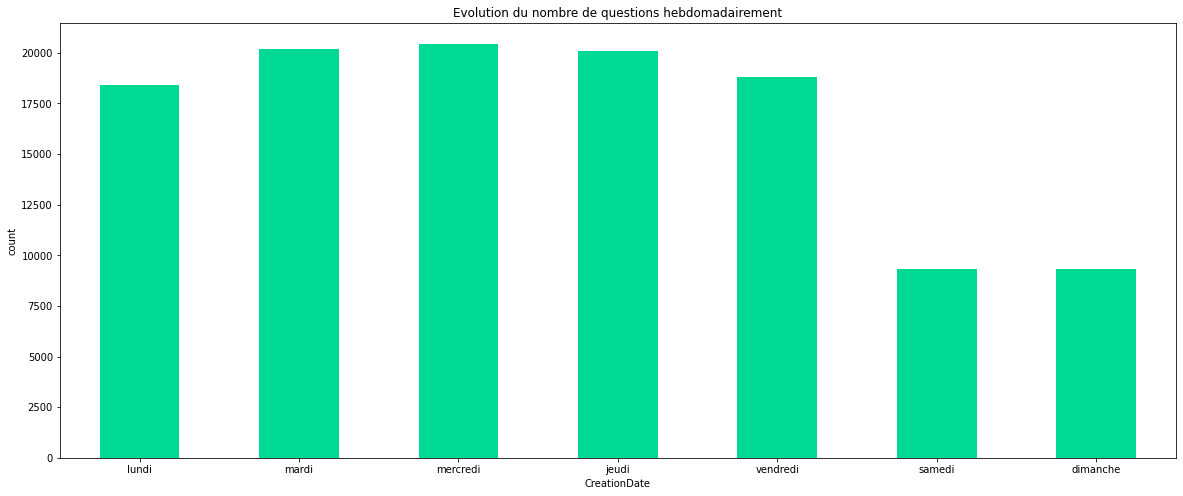

In [26]:
fig = plt.figure(figsize=(20, 8))
orders_per_days = data.groupby(
    data["CreationDate"].dt.dayofweek).count()["Id"]
ax = orders_per_days.plot(color="#00d994", kind='bar')
ax.set_ylabel("count")
plt.title(f"Evolution du nombre de questions hebdomadairement")
plt.xticks(np.arange(0, 7), ['lundi',
                             'mardi', 'mercredi', 'jeudi',
                             'vendredi', 'samedi',
                             'dimanche'], rotation='horizontal')
plt.show()

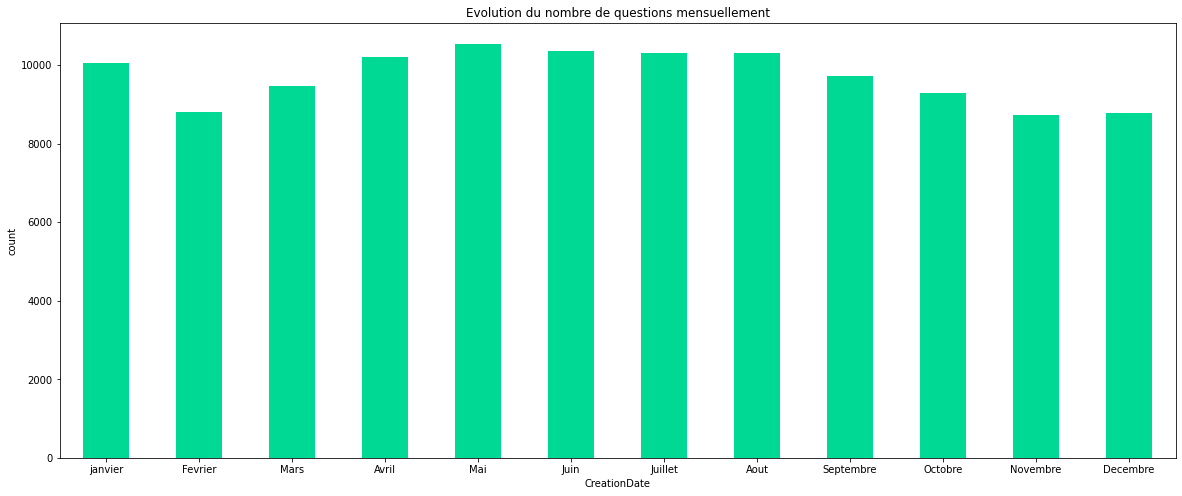

In [27]:
fig = plt.figure(figsize=(20, 8))
orders_per_days = data.groupby(
    data["CreationDate"].dt.month).count()["Id"]
ax = orders_per_days.plot(color="#00d994", kind='bar')
ax.set_ylabel("count")
plt.title(f"Evolution du nombre de questions mensuellement")
plt.xticks(np.arange(0, 12), ['janvier',
                              'Fevrier',
                              'Mars', 'Avril', 'Mai', 'Juin', 'Juillet',
                              'Aout', 'Septembre', 'Octobre',
                              'Novembre', 'Decembre'], rotation='horizontal')
plt.show()

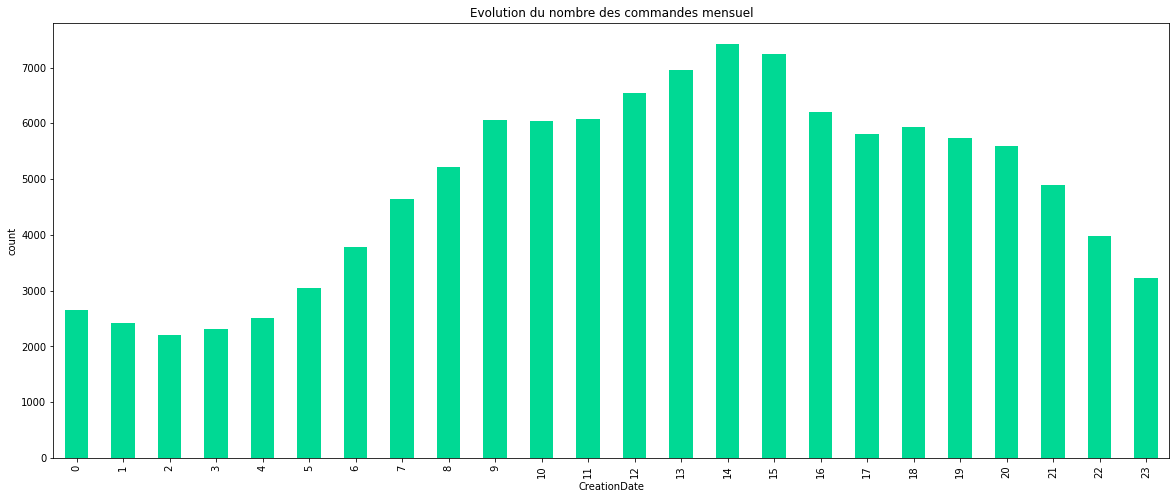

In [28]:
fig = plt.figure(figsize=(20, 8))
orders_per_days = data.groupby(
    data["CreationDate"].dt.hour).count()["Id"]
ax = orders_per_days.plot(color="#00d994", kind='bar')
ax.set_ylabel("count")

plt.title(f"Evolution du nombre des commandes mensuel")
plt.show()

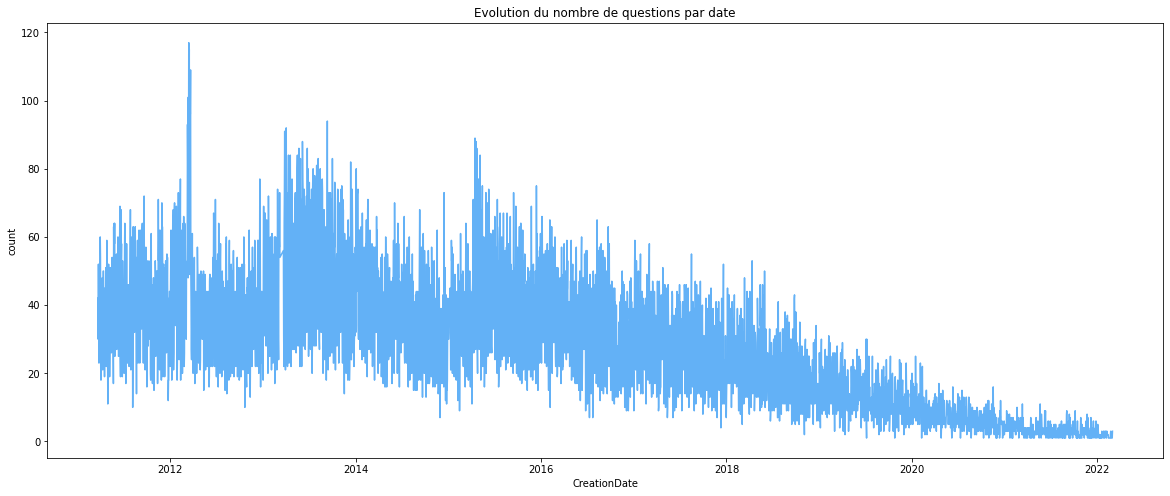

In [29]:
fig = plt.figure(figsize=(20, 8))
orders_per_days = data.groupby(data["CreationDate"].dt.date).count()["Id"]
ax = orders_per_days.plot(color="#63B1F6")
ax.set_ylabel("count")
plt.title(f"Evolution du nombre de questions par date")
plt.show()

Le jeu de données ne compte pas de valeurs nulles. La variable Id ne compte que des valeurs uniques, nous pouvons donc l'utiliser en index 

In [30]:
data.set_index('Id', inplace=True)

/home/ismail/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [31]:
data.shape

(116569, 10)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116569 entries, 5767325 to 71063730
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   CreationDate  116569 non-null  datetime64[ns]
 1   Title         116569 non-null  object        
 2   Body          116569 non-null  object        
 3   Tags          116569 non-null  object        
 4   ViewCount     116569 non-null  object        
 5   CommentCount  116569 non-null  object        
 6   AnswerCount   116569 non-null  object        
 7   Score         116569 non-null  object        
 8   up            101778 non-null  object        
 9   down          101778 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 9.8+ MB


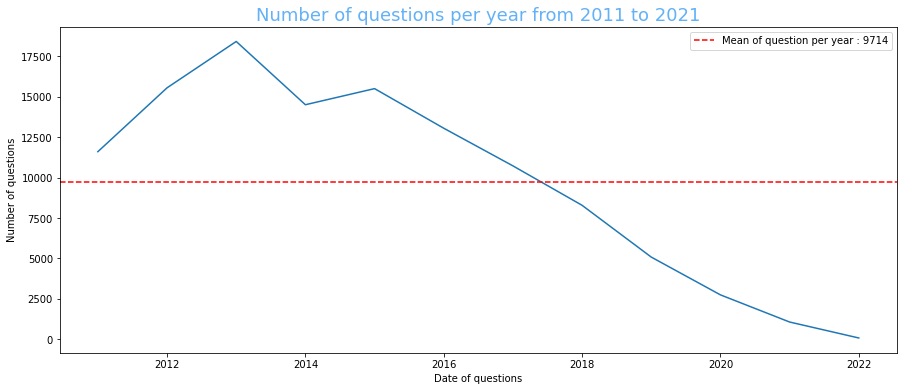

In [33]:
# Grouper with 1 year delta
gbyear = data.groupby(data.CreationDate.dt.year).agg({'Title': 'count'})
# Plot evolution
fig = plt.figure(figsize=(15,6))
sns.lineplot(data=gbyear, x=gbyear.index, y='Title')
plt.axhline(gbyear.Title.mean(), 
            color="r", linestyle='--',
            label="Mean of question per year : {:04d}"\
                   .format(int(gbyear.Title.mean())))
plt.xlabel("Date of questions")
plt.ylabel("Number of questions")
plt.title("Number of questions per year from 2011 to 2021",
          fontsize=18, color="#63B1F6")
plt.legend()
plt.show()

 longeur des titres

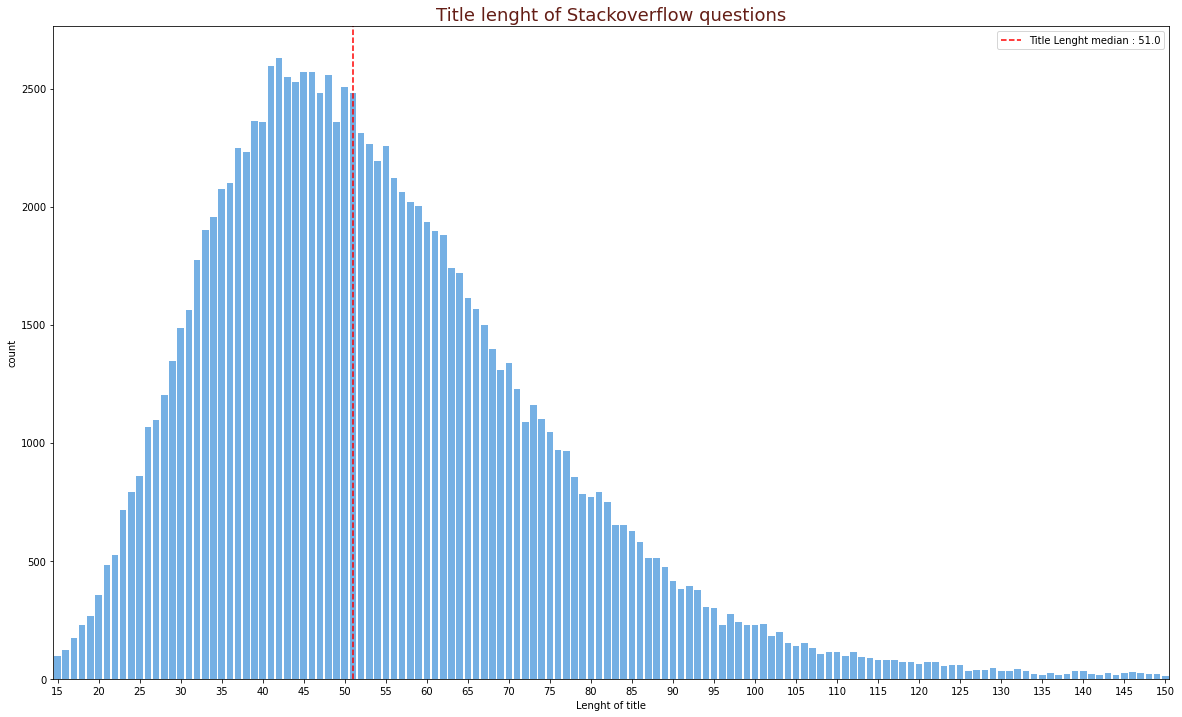

In [34]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=data.Title.str.len(), color='#63B1F6')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(data.Title.str.len().median() - data.Title.str.len().min(),
            color="r", linestyle='--',
            label="Title Lenght median : "+str(data.Title.str.len().median()))
ax.set_xlabel("Lenght of title")
plt.title("Title lenght of Stackoverflow questions",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

 longeur des différents body

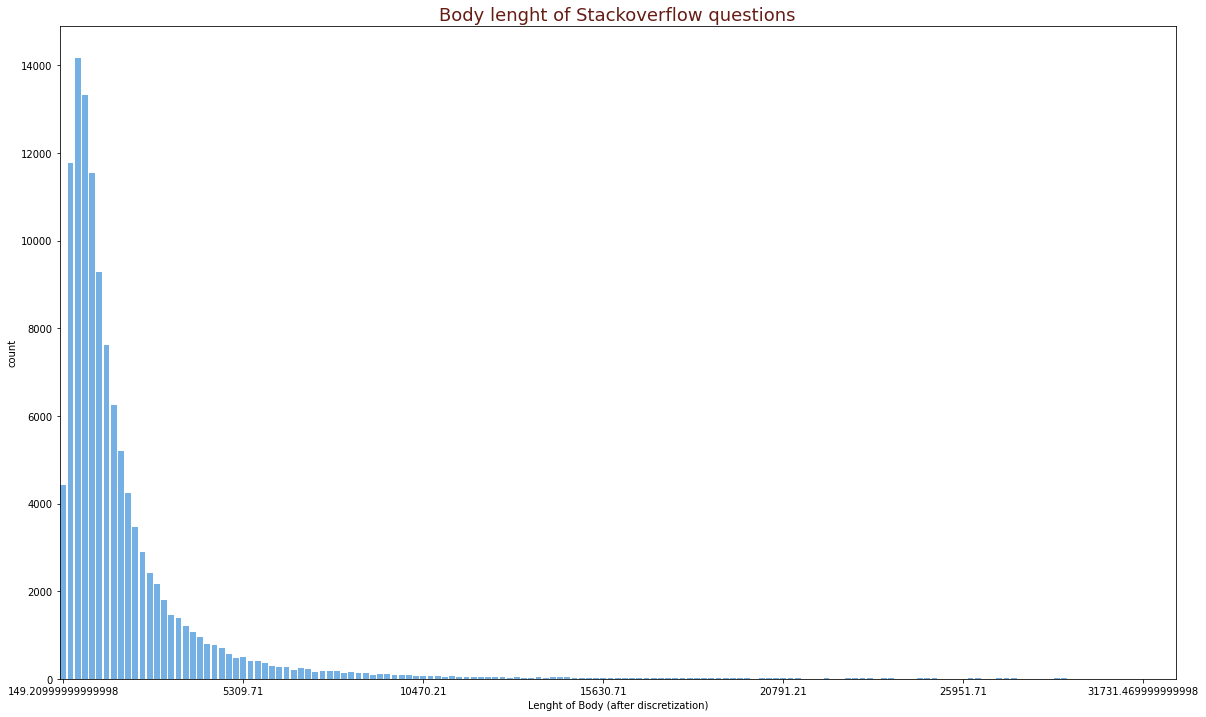

In [36]:
# Discretizer for Body characters lenght
X = pd.DataFrame(data.Body.str.len())

# Sklearn discretizer with 200 bins
discretizer = KBinsDiscretizer(n_bins=200,
                               encode='ordinal',
                               strategy='uniform')
body_lenght = discretizer.fit_transform(X)
body_lenght = discretizer.inverse_transform(body_lenght)
body_lenght = pd.Series(body_lenght.reshape(-1))

fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=body_lenght, color='#63B1F6')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
ax.set_xlabel("Lenght of Body (after discretization)")
plt.title("Body lenght of Stackoverflow questions",
          fontsize=18, color="#641E16")
# plt.legend()
plt.show()

On remarque que la majeur partie des questions compte moins de 4000 caractères (balises HTML compris) mais certains posts dépassent les 31 000 caractères. Nous allons filtrer notre jeu de données pour conserver uniquement les questions de moins de 4 000 caractères afin de ne pas compliquer le NLP plus que nécessaire.

In [37]:
# Filter data on body lenght
data = data[data.Body.str.len() < 4000]
data.shape

(105834, 10)

<a name='an'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Analyse des tags
        </h1>
    </div>
</div>

extraction des tags

In [38]:
def tagExtractor(tags):
    val = tags.replace("><", ",").replace("<", "").replace(">", "")
    return val
data['Tags']= data['Tags'].apply(tagExtractor)   

In [39]:
data['Tags'].head(10)

Id
5767325                                    javascript,arrays
7244321           git,github,synchronization,repository,fork
8710619    java,casting,operators,variable-assignment,ass...
6245570                                git,branch,git-branch
8467424                                    bash,echo,newline
5515310                 javascript,null,comparison,undefined
9537392                      git,branch,git-branch,git-fetch
5874652                      javascript,jquery,dom,attr,prop
6127328     git,github,version-control,branch,feature-branch
8312459                              javascript,loops,object
Name: Tags, dtype: object

serealisation et compatges des variables

In [40]:
def count_split_tags(df, column='Tags', separator=','):
    list_words = []
    for word in df[column].str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag").agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

In [41]:
tags_list = count_split_tags(df=data)
print("Le jeu de données compte {} tags.".format(tags_list.shape[0]))

Le jeu de données compte 15698 tags.


In [42]:
tags_list.sort_values('tag_count',ascending=False).head(50).index.to_list()

['c++',
 'javascript',
 'java',
 'c#',
 'python',
 'android',
 'c',
 'php',
 'html',
 'ios',
 'css',
 'jquery',
 '.net',
 'algorithm',
 'c++11',
 'arrays',
 'performance',
 'swift',
 'node.js',
 'sql',
 'mysql',
 'r',
 'string',
 'objective-c',
 'git',
 'linux',
 'multithreading',
 'angular',
 'sql-server',
 'xcode',
 'regex',
 'json',
 'python-3.x',
 'windows',
 'language-lawyer',
 'asp.net',
 'reactjs',
 'gcc',
 'iphone',
 'angularjs',
 'ruby',
 'pointers',
 'macos',
 'google-chrome',
 'haskell',
 'bash',
 'java-8',
 'visual-studio',
 'typescript',
 'ruby-on-rails']

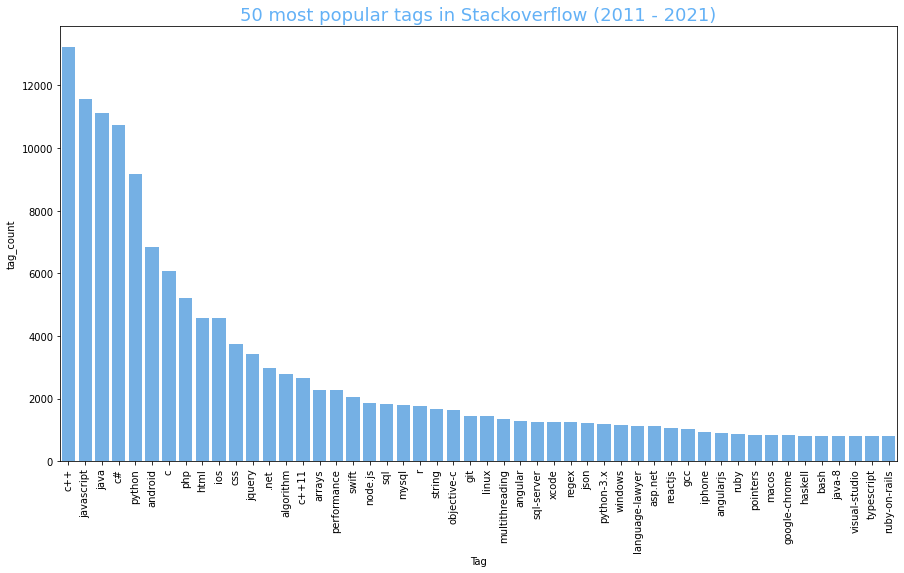

In [43]:
# Plot the results of splits
bestTags = tags_list.sort_values('tag_count',ascending=False).iloc[:50]
fig = plt.figure(figsize=(15, 8))
sns.barplot(data=bestTags,
            x=bestTags.index,
            y="tag_count", color="#63B1F6")
plt.xticks(rotation=90)
plt.title("50 most popular tags in Stackoverflow (2011 - 2021)",
          fontsize=18, color="#63B1F6")
plt.show()

Dans les 50 tags les plus populaires sur StackOverflow, les tags C++, C# et java , javascript sont sans surprise dans le top 4. Le dataset compte plus de 15698 tags différents pour la période 2011 - 2022.

- visualisations dans un nuage de mots des 500 premiers mots par catégories 

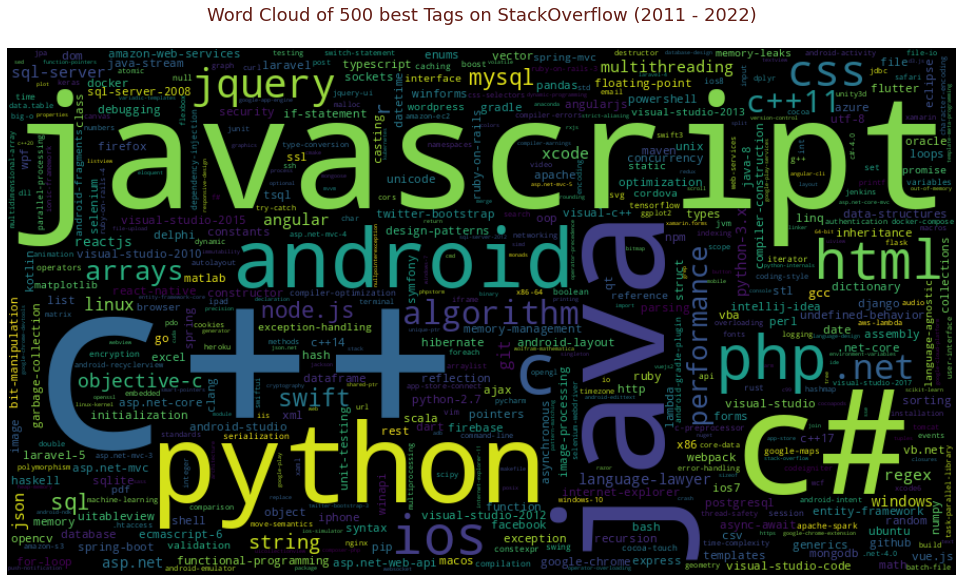

In [44]:
# Plot word cloud with tags_list (frequencies)
fig = plt.figure( figsize=(17, 12))
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False).generate_from_frequencies(tags_list.to_dict()['tag_count'])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2011 - 2022)\n",
          fontsize=18, color="#641E16")
plt.show()

visualisation des top tags par annees

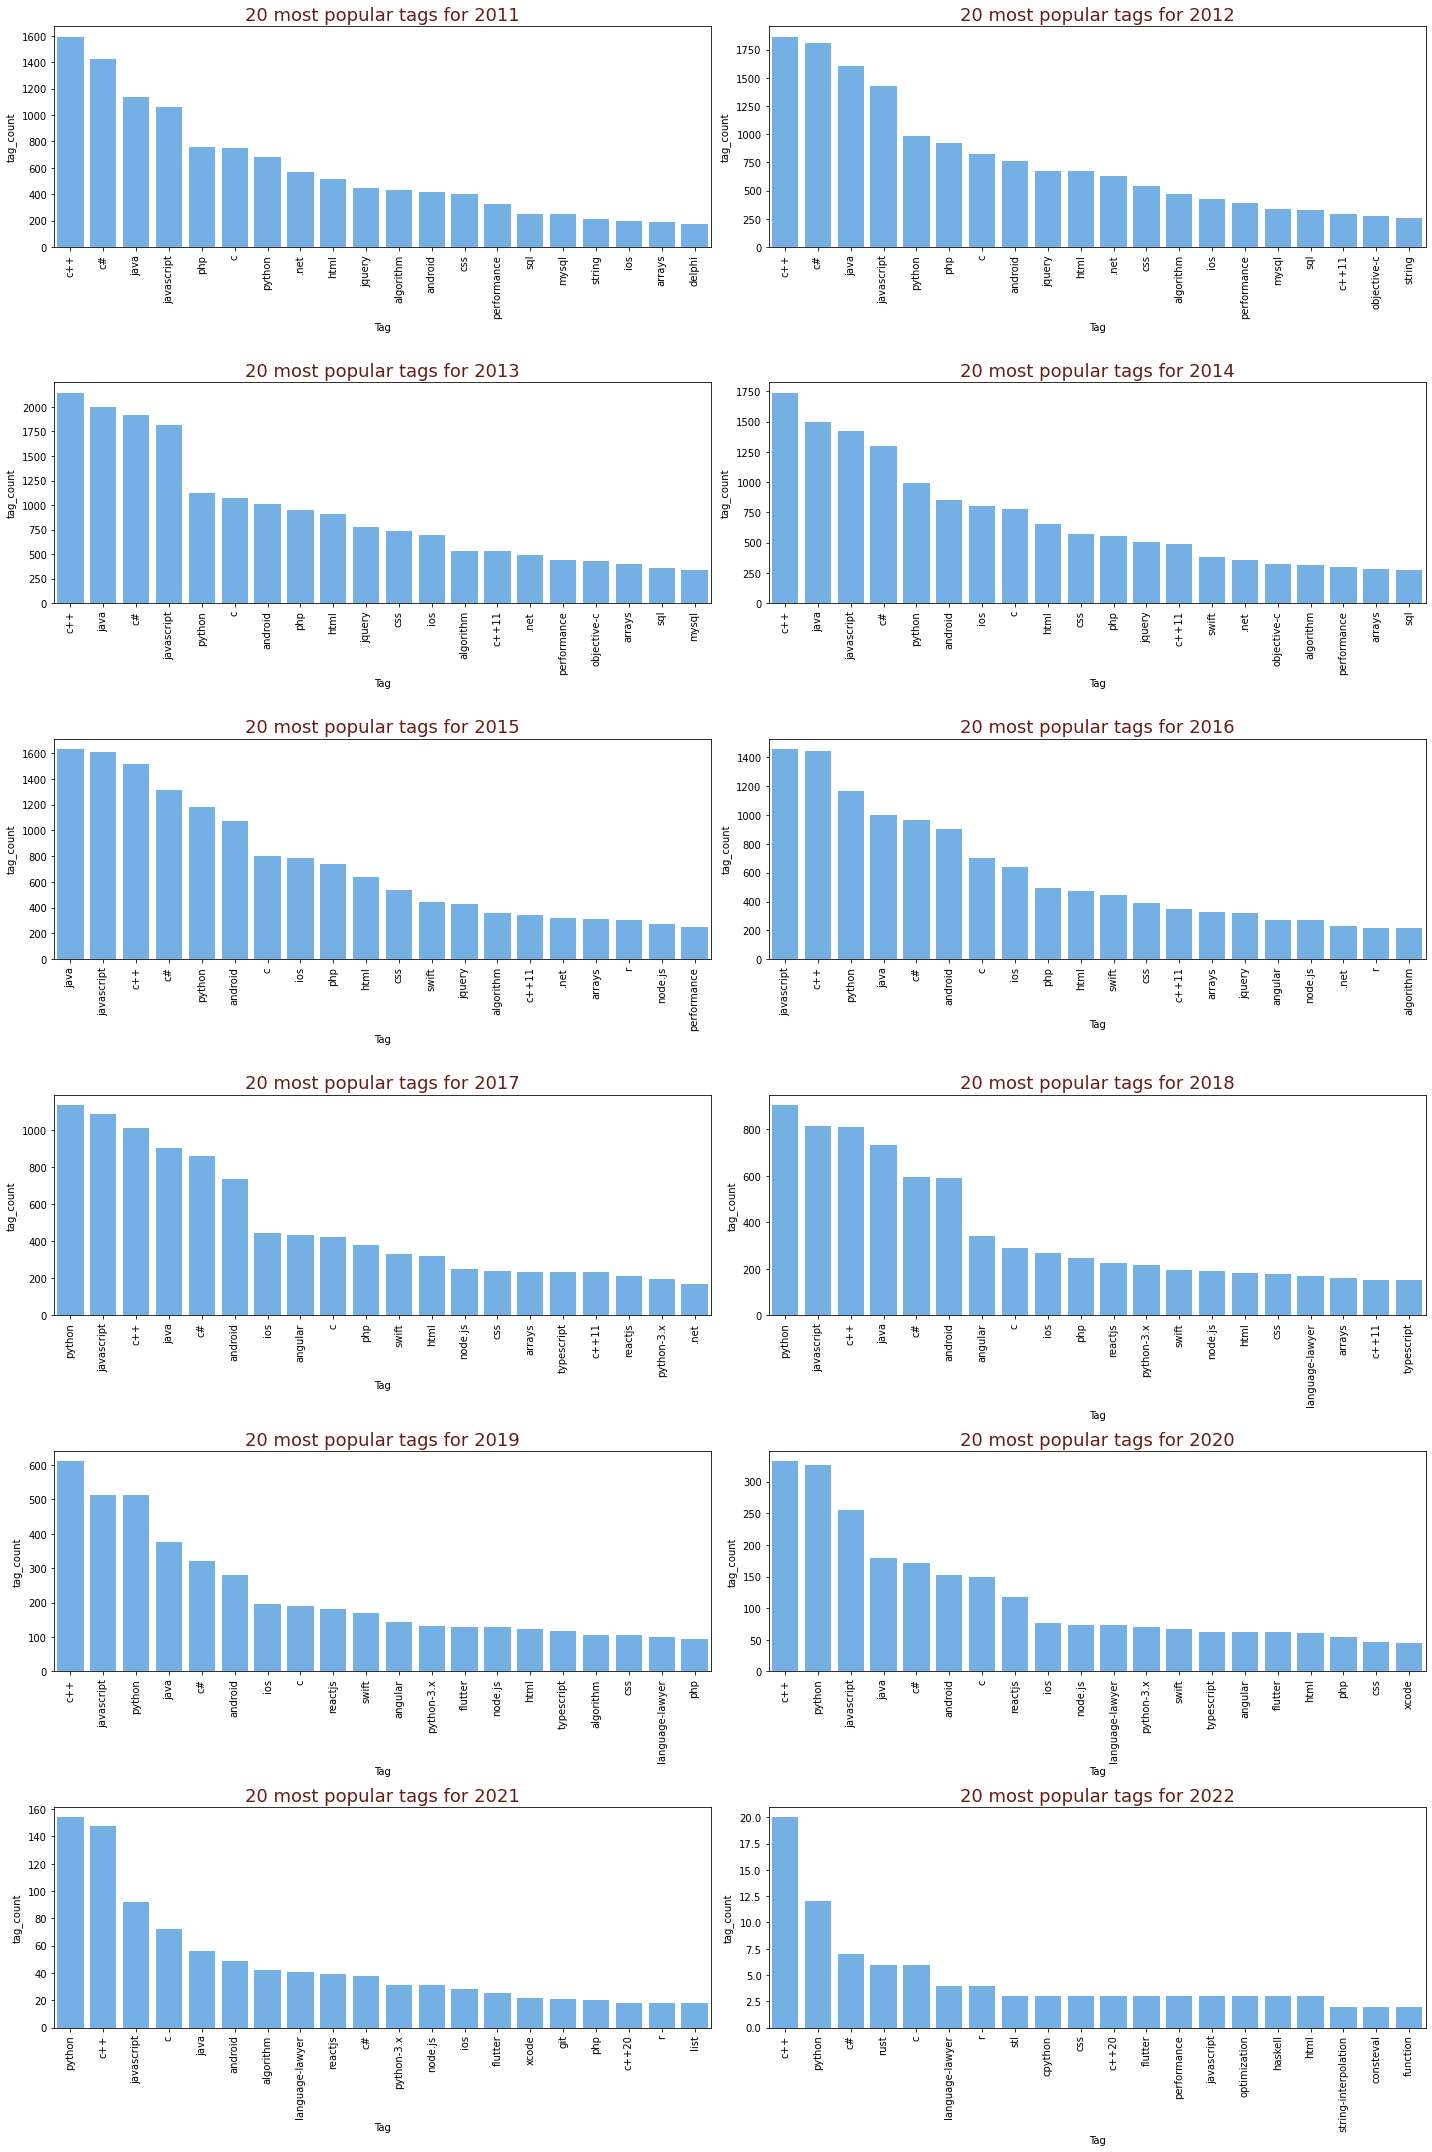

In [45]:
listyear = data["CreationDate"].dt.year.unique().tolist()
subplots = len(listyear)
cols = 2
rows = subplots // cols
rows += subplots % cols
position = range(1, subplots + 1)

# Plot popular tags for each year
fig = plt.figure(1, figsize=(20, 30))
for k in range(subplots):
    subset = data[data["CreationDate"].dt.year == listyear[k]]
    temp_list = count_split_tags(df=subset, column='Tags', separator=',')
    ax = fig.add_subplot(rows, cols, position[k])
    sns.barplot(data=temp_list.iloc[0:20, :],
            x=temp_list.iloc[0:20, :].index,
            y="tag_count", color='#63B1F6')
    plt.xticks(rotation=90)
    ax.set_title("20 most popular tags for {}".format(listyear[k]),
                 fontsize=18, color="#641E16")

fig.tight_layout()
plt.show()



On remarque en effet que les centres d'intérêt évoluent en fonction des années. Cependant, on retrouve les principaux languages et framework informatiques dans les premières places.

- nombre de Tags par question 

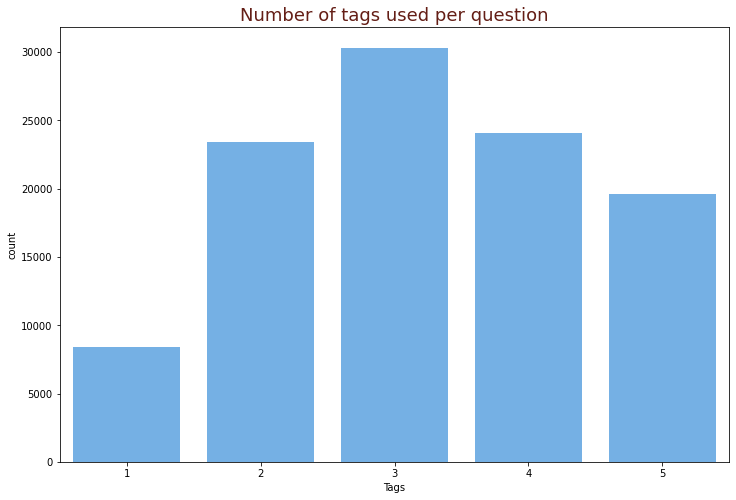

In [46]:
# Create a list of Tags and count the number
data['Tags_list'] = data['Tags'].str.split(',')
data['Tags_count'] = data['Tags_list'].apply(lambda x: len(x))

# Plot the result
fig = plt.figure(figsize=(12, 8))
ax = sns.countplot(x=data.Tags_count, color="#63B1F6")
ax.set_xlabel("Tags")
plt.title("Number of tags used per question",
          fontsize=18, color="#641E16")
plt.show()

Pour la majorité des questions StackOverflow analysées, 3 tags sont utilisés. 
un classification multi label seras donc choisi pour ce projet

In [47]:
data.head()

,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score,up,down,Tags_list,Tags_count
Id,,,,,,,,,,,,
5767325,2011-04-23 22:17:18,How can I remove a specific item from an array?,"<p>I have an array of numbers and I'm using the <code>.push()</code> method to add elements to it.</p>\n\n<p>Is there a simple way to remove a specific element from an array?</p>\n\n<p>I'm looking for the equivalent of something like:</p>\n\n<pre class=""lang-js prettyprint-override""><code>array.remove(number);\n</code></pre>\n\n<p>I have to use <em>core</em> JavaScript. Frameworks are not allowed.</p>\n","javascript,arrays",9623441,9,127,10385,10404,0,"[javascript, arrays]",2
7244321,2011-08-30 13:53:00,How do I update or sync a forked repository on GitHub?,"<p>I forked a project, applied several fixes and created a pull request which was accepted. A few days later, another change was made by another contributor. So my fork doesn't contain that change.</p>\n<p>How can I get that change into my fork? Do I need to delete and re-create my fork when I have further changes to contribute? Or is there an update button?</p>\n","git,github,synchronization,repository,fork",1025579,8,31,4359,4363,0,"[git, github, synchronization, repository, fork]",5
8710619,2012-01-03 10:10:32,"Why don't Java's +=, -=, *=, /= compound assignment operators require casting?","<p>Until today, I thought that for example:</p>\n\n<pre><code>i += j;\n</code></pre>\n\n<p>Was just a shortcut for:</p>\n\n<pre><code>i = i + j;\n</code></pre>\n\n<p>But if we try this:</p>\n\n<pre><code>int i = 5;\nlong j = 8;\n</code></pre>\n\n<p>Then <code>i = i + j;</code> will not compile but <code>i += j;</code> will compile fine.</p>\n\n<p>Does it mean that in fact <code>i += j;</code> is a shortcut for something like this\n<code>i = (type of i) (i + j)</code>?</p>\n","java,casting,operators,variable-assignment,assignment-operator",309790,14,11,3779,3791,0,"[java, casting, operators, variable-assignment, assignment-operator]",5
6245570,2011-06-05 20:13:43,How to get the current branch name in Git?,"<p>I'm from a Subversion background and, when I had a branch, I knew what I was working on with ""These working files point to this branch"".</p>\n\n<p>But with Git I'm not sure when I am editing a file in NetBeans or Notepad++, whether it's tied to the master or another branch.</p>\n\n<p>There's no problem with <code>git</code> in bash, it tells me what I'm doing.</p>\n","git,branch,git-branch",2313256,8,45,3372,3379,0,"[git, branch, git-branch]",3
8467424,2011-12-11 21:01:54,Echo newline in Bash prints literal \n,"<p>In Bash, tried this:</p>\n<pre><code>echo -e &quot;Hello,\nWorld!&quot;\n</code></pre>\n<p>But it doesn't print a newline, only <code>\n</code>. How can I make it print the newline?</p>\n<p>I'm using <a href=""https://en.wikipedia.org/wiki/Ubuntu_version_history#Ubuntu_11.04_.28Natty_Narwhal.29"" rel=""noreferrer"">Ubuntu 11.04</a> (Natty Narwhal).</p>\n","bash,echo,newline",2790377,10,20,3050,3059,0,"[bash, echo, newline]",3


## sélectionner des questions qui comportent au minimum un des 50 meilleurs tags et suppression des autres tags :

In [48]:
data.shape

(105834, 12)

In [49]:
def filter_tag(x, top_list):
    temp_list = []
    for item in x:
        if (item in top_list):
            temp_list.append(item)
    return temp_list

top_tags = list(tags_list.iloc[0:50].index)
data['Tags_list'] = data['Tags_list'].apply(lambda x: filter_tag(x, top_tags))
data['number_of_tags'] = data['Tags_list'].apply(lambda x : len(x))
data = data[data.number_of_tags > 0]
print("New size of dataset : {} questions.".format(data.shape[0]))

New size of dataset : 94488 questions.


In [50]:
data.shape

(94488, 13)

In [51]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata
nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

<a name='re'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          remove html tag and escaping code sample in questions
        </h1>
    </div>
</div>

- Dans stackoverflow les utilisateurs partage beaucoup leur codes informatiques, cependant les modeles nlp ne sont pas concus pour analyser du code informatique et seras plus lourd et moins efficace .
Nous allons donc supprimer les codes informatiques de nos dictionnaires de mots, en supprimant le contenu des balises de code( avec beautifulSoup)

In [52]:
from bs4 import BeautifulSoup
from bs4 import Comment
#remove code block and technical tags words in generally
#prevent to inject wrong word in vocabulary
def cleanMe(txt):
    soup = BeautifulSoup(txt, "lxml")
    [x.extract() for x in soup.find_all('code')]
    [x.extract() for x in soup.find_all('script')]
    [x.extract() for x in soup.find_all('style')]
    [x.extract() for x in soup.find_all('meta')]
    [x.extract() for x in soup.find_all('noscript')]
    [x.extract() for x in soup.find_all(text=lambda text:isinstance(text, Comment))]
    res = soup.get_text()
    return soup.get_text()
cleanMe('<code>testtest</code>sdsdsdsd<html><scrip></scrip></html>')

'sdsdsdsd'

In [53]:
data['Body'] = data['Body'].apply(cleanMe)

In [54]:
data['Body'].head()

Id
5767325    I have an array of numbers and I'm using the  ...
7244321    I forked a project, applied several fixes and ...
8710619    Until today, I thought that for example:\n\nWa...
6245570    I'm from a Subversion background and, when I h...
8467424    In Bash, tried this:\n\nBut it doesn't print a...
Name: Body, dtype: object

### detection des langues

suppression des questions non anglaise

In [55]:
# pip install langdetect

In [57]:
from langdetect import detect
# combining headline and article text
data['full_text'] = data["Title"].map(str)+ ' ' + data["Body"]

def detect_lang(text):
    return detect(text)

data['langue']=data['full_text'].apply(detect_lang)

In [58]:
data['langue'].value_counts()

en    94479
sv        2
es        2
da        1
no        1
fr        1
bn        1
af        1
Name: langue, dtype: int64

In [59]:
data = data[data['langue']=='en']
data.shape

(94479, 15)

In [62]:
data.head(2)

,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score,up,down,Tags_list,Tags_count,number_of_tags,full_text,langue
Id,,,,,,,,,,,,,,,
5767325,2011-04-23 22:17:18,How can I remove a specific item from an array?,I have an array of numbers and I'm using the method to add elements to it.\nIs there a simple way to remove a specific element from an array?\nI'm looking for the equivalent of something like:\n\nI have to use core JavaScript. Frameworks are not allowed.\n,"javascript,arrays",9623441,9,127,10385,10404,0,"[javascript, arrays]",2,2,How can I remove a specific item from an array? I have an array of numbers and I'm using the method to add elements to it.\nIs there a simple way to remove a specific element from an array?\nI'm looking for the equivalent of something like:\n\nI have to use core JavaScript. Frameworks are not allowed.\n,en
7244321,2011-08-30 13:53:00,How do I update or sync a forked repository on GitHub?,"I forked a project, applied several fixes and created a pull request which was accepted. A few days later, another change was made by another contributor. So my fork doesn't contain that change.\nHow can I get that change into my fork? Do I need to delete and re-create my fork when I have further changes to contribute? Or is there an update button?\n","git,github,synchronization,repository,fork",1025579,8,31,4359,4363,0,[git],5,1,"How do I update or sync a forked repository on GitHub? I forked a project, applied several fixes and created a pull request which was accepted. A few days later, another change was made by another contributor. So my fork doesn't contain that change.\nHow can I get that change into my fork? Do I need to delete and re-create my fork when I have further changes to contribute? Or is there an update button?\n",en


<a name='se'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
           Analyse des sequences de mots
        </h1>
    </div>
</div>
- nous allons utiliser nltk.pos_tag pour identifier la nature de chaque mot du corpus afin de pouvoir ensuite conserver uniquement les noms.



La connaissance de la structure et de la syntaxe du langage est utile dans de nombreux domaines tels que le traitement de texte, l'annotation et l'analyse pour d'autres opérations telles que la classification ou la synthèse de texte. Les techniques d'analyse typiques pour comprendre la syntaxe du texte sont mentionnées ci-dessous.
- Balisage des parties du discours (POS)
- Analyse superficielle ou segmentation
- Analyse de circonscription
- Analyse des dépendances

In [63]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 70)
pd.set_option('display.min_rows', 70)
pd.set_option('display.expand_frame_repr', True)

In [64]:
sentence = str(data.iloc[1].full_text)
sentence

"How do I update or sync a forked repository on GitHub? I forked a project, applied several fixes and created a pull request which was accepted. A few days later, another change was made by another contributor. So my fork doesn't contain that change.\nHow can I get that change into my fork? Do I need to delete and re-create my fork when I have further changes to contribute? Or is there an update button?\n"

In [65]:
sentence_nlp = nlp(sentence)

## segmentation

L'analyse superficielle, également connue sous le nom d'analyse légère ou de segmentation, est une technique populaire de traitement du langage naturel consistant à analyser la structure d'une phrase pour la décomposer en ses plus petits constituants (qui sont des jetons tels que des mots) et les regrouper en phrases de niveau supérieur. . Cela inclut les balises POS ainsi que les expressions d'une phrase.

<img src='https://miro.medium.com/max/1176/1*dq-BbcMMkLmDDcSCdzQIzA.png'></img>


- **Phrase nominale (NP)**: Ce sont des phrases où un nom agit comme mot principal. Les phrases nominales agissent comme sujet ou objet d'un verbe.
- **Phrase verbale (VP)** : ces phrases sont des unités lexicales qui ont un verbe agissant comme mot principal. Habituellement, il existe deux formes de phrases verbales. Une forme a les composants verbaux ainsi que d'autres entités telles que des noms, des adjectifs ou des adverbes comme parties de l'objet.
- **Phrase adjective (ADJP)**: Ce sont des phrases avec un adjectif comme mot principal. Leur rôle principal est de décrire ou de qualifier les noms et les pronoms dans une phrase, et ils seront placés soit avant, soit après le nom ou le pronom.
- **Phrase adverbiale (ADVP)**: Ces phrases agissent comme des adverbes puisque l'adverbe agit comme le mot principal dans la phrase. Les expressions adverbiales sont utilisées comme modificateurs pour les noms, les verbes ou les adverbes eux-mêmes en fournissant des détails supplémentaires qui les décrivent ou les qualifient.
- **Phrase prépositionnelle (PP)**: Ces phrases contiennent généralement une préposition comme mot principal et d'autres composants lexicaux comme les noms, les pronoms, etc. Ceux-ci agissent comme un adjectif ou un adverbe décrivant d'autres mots ou expressions.

**Pour essayer de repondre a notre problematique, nous allons conserver que les noms de notre corpus, afin de supprimer les parties inutiles du discours**

In [66]:
print('POS tagging with nltk')
# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
display(pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag']))

POS tagging with nltk


,Word,POS tag
0,How,WRB
1,do,VBP
2,I,PRP
3,update,VB
4,or,CC
5,sync,VB
6,a,DT
7,forked,JJ
8,repository,NN
9,on,IN


In [67]:
print('POS tagging with Spacy ')
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
display(pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type']))

POS tagging with Spacy 


,Word,POS tag,Tag type
0,How,WRB,ADV
1,do,VBP,AUX
2,I,PRP,PRON
3,update,VB,VERB
4,or,CC,CCONJ
5,sync,VB,VERB
6,a,DT,DET
7,forked,JJ,ADJ
8,repository,NN,NOUN
9,on,IN,ADP


In [68]:
print('POS tagging with nltk')
# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(top_tags)
display(pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag']))

POS tagging with nltk


,Word,POS tag
0,c++,NN
1,javascript,NN
2,java,NN
3,c#,NN
4,python,NN
5,android,JJ
6,c,NN
7,php,NN
8,html,NN
9,ios,NNS


<a name='rec'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
           Reconnaissance d'entité nommée
        </h1>
    </div>
</div>

- Dans tout document texte, il existe des termes particuliers qui représentent des entités spécifiques qui sont plus informatifs et ont un contexte unique. Ces entités sont connues sous le nom d'entités nommées , qui font plus spécifiquement référence à des termes qui représentent des objets du monde réel tels que des personnes, des lieux, des organisations, etc., qui sont souvent désignés par des noms propres. 
- Une approche naïve pourrait être de les trouver en regardant les phrases nominales dans les documents textuels. 
- La reconnaissance d'entités nommées (NER), également connue sous le nom de segmentation/extraction d'entités, est une technique populaire utilisée dans l'extraction d'informations pour identifier et segmenter les entités nommées et les classer ou les catégoriser dans diverses classes prédéfinies.

In [69]:
str(top_tags)

"['c++', 'javascript', 'java', 'c#', 'python', 'android', 'c', 'php', 'html', 'ios', 'css', 'jquery', '.net', 'algorithm', 'c++11', 'arrays', 'performance', 'swift', 'node.js', 'sql', 'mysql', 'r', 'string', 'objective-c', 'git', 'linux', 'multithreading', 'angular', 'sql-server', 'xcode', 'regex', 'json', 'python-3.x', 'windows', 'language-lawyer', 'asp.net', 'reactjs', 'gcc', 'iphone', 'angularjs', 'ruby', 'pointers', 'macos', 'google-chrome', 'haskell', 'bash', 'java-8', 'visual-studio', 'typescript', 'ruby-on-rails']"

In [70]:
# sentence = str(data.iloc[7].full_text)
sentence = str([x.lower() for x in top_tags])
sentence_nlp = nlp(sentence)
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(c++, 'WORK_OF_ART'), (javascript, 'PERSON'), (java, 'ORG'), (python, 'WORK_OF_ART'), (android, 'PERSON'), (ios, 'ORG'), (', 'WORK_OF_ART'), (node.js, 'WORK_OF_ART'), (', 'WORK_OF_ART'), (sql, 'ORG'), (mysql, 'WORK_OF_ART'), (linux, 'WORK_OF_ART'), (', 'WORK_OF_ART'), (multithreading, 'WORK_OF_ART'), (', 'WORK_OF_ART'), (xcode, 'ORG'), (json, 'PERSON'), (', 'WORK_OF_ART'), (python-3.x, 'WORK_OF_ART'), (', 'WORK_OF_ART'), (angularjs, 'PERSON'), (macos, 'ORG')]


Malheuresement la reconnaissance d'entité nommée ne va pas nous aider dans notre projet...

In [71]:
str(top_tags)

"['c++', 'javascript', 'java', 'c#', 'python', 'android', 'c', 'php', 'html', 'ios', 'css', 'jquery', '.net', 'algorithm', 'c++11', 'arrays', 'performance', 'swift', 'node.js', 'sql', 'mysql', 'r', 'string', 'objective-c', 'git', 'linux', 'multithreading', 'angular', 'sql-server', 'xcode', 'regex', 'json', 'python-3.x', 'windows', 'language-lawyer', 'asp.net', 'reactjs', 'gcc', 'iphone', 'angularjs', 'ruby', 'pointers', 'macos', 'google-chrome', 'haskell', 'bash', 'java-8', 'visual-studio', 'typescript', 'ruby-on-rails']"

<a name='txt'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
           Text cleaning
        </h1>
    </div>
</div>

- Nous allons à présent réaliser plusieurs opérations de Text cleaning pour que nos données soient exploitables par les algorithmes de NLP :

    - Suppression de tous les mots autres que les noms
    - Mettre tout le texte en minuscules
    - Supprimer les caractères Unicode 
    - Suppression des espaces supplémentaires
    - Suppression de la ponctuation
    - Suppression des liens
    - Supprimer les nombres
    - Supression des stop words en langue Anglaise
    - Lemmatisation
    - Conserver les '++' de c++ et '#' pour c#
    
    
Lemmatisation. Ce procédé consiste à prend le mot à sa forme racine appelée Lemme. Cela nous permet d'amener les mots à leur forme "dictionnaire"    

In [72]:
def remove_specific_typeOfwords(txt, nlp):
    doc = nlp(txt)
    list_text_row = []
    for token in doc:
        if(token.pos_ not in ['POS','ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NUM','PART','PUNCT','SCONJ','SYM','VERB','X','SPACE']):
            list_text_row.append(token.text)
    join_text_row = " ".join(list_text_row)
    join_text_row = join_text_row.lower().replace("c #", "c#")
    return join_text_row

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


In [73]:
from nltk import regexp_tokenize
def text_cleaner(txt, nlp):
    # Remove specific type of word
    txt = remove_specific_typeOfwords(txt, nlp)
    # Case normalization
    txt = txt.lower()
    # Remove unicode characters
    txt = txt.encode("ascii", "ignore").decode()
    # Remove English contractions
    txt = re.sub("\'\w+", '', txt)
    # Remove accent
    txt = remove_accented_chars(txt)   
    # Remove ponctuation but not # or ++
#     txt = re.sub('[^\\w\\s#]', '', txt)
    txt = re.sub('[^\\w\\s(#|++)]', '', txt)
    # Remove links
    txt = re.sub(r'http*\S+', '', txt)
    # Remove numbers
    txt = re.sub(r'\w*\d+\w*', '', txt)
    # Remove extra spaces
    txt = re.sub('\s+', ' ', txt)    
    # Tokenization with exception for C# and c++
    txt = regexp_tokenize(txt, pattern=r"\s|[\.,;']", gaps=True)
    # remove # caracter alone after tokenization
    txt = [element for element in txt if element != '#']
#     txt = [element for element in txt if len(element) != 1]
#     # List of stop words in select language from NLTK
#     # Remove stop words   
    stop_words = stopwords.words("english")
#     # Remove stop words
    txt = [word for word in txt if word not in stop_words ]
#     # Lemmatizer
    wn = nltk.WordNetLemmatizer()
    txt = [wn.lemmatize(word) for word in txt]
        
    return txt

In [74]:
# Apply cleaner on Body
# Spacy features
# nlp = spacy.load('en_core_web_md', exclude=['tok2vec', 'ner', 'parser', 'attribute_ruler', 'lemmatizer'])
# data_sample = data[data['Tags'].str.contains('c#')].sample(100, random_state=21)
# nlp = spacy.load('en_core_web_md')
# data_sample['text_cleaned'] = data_sample['full_text'].apply(lambda text : text_cleaner(text, nlp))
# data_sample[['full_text','text_cleaned']].head()

In [75]:
nlp = spacy.load('en_core_web_md')
data['text_cleaned'] = data['full_text'].apply(lambda text : text_cleaner(text, nlp))
data[['full_text','text_cleaned']].head(3)

,full_text,text_cleaned
Id,,
5767325,How can I remove a specific item from an array? I have an array of numbers and I'm using the method to add elements to it.\nIs there a simple way to remove a specific element from an array?\nI'm looking for the equivalent of something like:\n\nI have to use core JavaScript. Frameworks are not allowed.\n,"[item, array, array, number, method, element, way, element, array, equivalent, something, core, javascript, framework]"
7244321,"How do I update or sync a forked repository on GitHub? I forked a project, applied several fixes and created a pull request which was accepted. A few days later, another change was made by another contributor. So my fork doesn't contain that change.\nHow can I get that change into my fork? Do I need to delete and re-create my fork when I have further changes to contribute? Or is there an update button?\n","[repository, github, project, fix, pull, request, day, change, contributor, fork, change, change, fork, fork, change, update, button]"
8710619,"Why don't Java's +=, -=, *=, /= compound assignment operators require casting? Until today, I thought that for example:\n\nWas just a shortcut for:\n\nBut if we try this:\n\nThen will not compile but will compile fine.\nDoes it mean that in fact is a shortcut for something like this\n?\n","[java, compound, assignment, operator, today, example, shortcut, fact, shortcut, something]"


In [76]:
data.columns

Index(['CreationDate', 'Title', 'Body', 'Tags', 'ViewCount', 'CommentCount',
       'AnswerCount', 'Score', 'up', 'down', 'Tags_list', 'Tags_count',
       'number_of_tags', 'full_text', 'langue', 'text_cleaned'],
      dtype='object')

In [77]:
data[['Tags','text_cleaned']].sample(3)

,Tags,text_cleaned
Id,,
30897961,"javascript,variable-assignment,ecmascript-6,destructuring","[structuring, assignment, destructuring, assignment, feature, copy, babel, repl, case, variable, converse, property, object, variable, name, object, object, initializer, syntax, u, name, object, kind, assignment]"
40256348,"sql,jpa,querydsl","[querydsl, exception, argument, type, mismatch, projection, bean, onetomany, manytomany, association, association, entity, query, query, data, database, problem, querydsl, hibernate, introspection, entity, exception, problem, method, parameter, id, entity, list, role, problem, query, querydsl, querydsl, result]"
8495359,"java,templates,velocity","[velocity, directive, whitespace, apache, velocity, directive, whitespace, example, something, line, statement, statement, comment, end, line, way, velocity, engine, directive, something, thanks]"


In [78]:
top_tags

['c++',
 'javascript',
 'java',
 'c#',
 'python',
 'android',
 'c',
 'php',
 'html',
 'ios',
 'css',
 'jquery',
 '.net',
 'algorithm',
 'c++11',
 'arrays',
 'performance',
 'swift',
 'node.js',
 'sql',
 'mysql',
 'r',
 'string',
 'objective-c',
 'git',
 'linux',
 'multithreading',
 'angular',
 'sql-server',
 'xcode',
 'regex',
 'json',
 'python-3.x',
 'windows',
 'language-lawyer',
 'asp.net',
 'reactjs',
 'gcc',
 'iphone',
 'angularjs',
 'ruby',
 'pointers',
 'macos',
 'google-chrome',
 'haskell',
 'bash',
 'java-8',
 'visual-studio',
 'typescript',
 'ruby-on-rails']

In [ ]:
data.loc[data['Tags_list'].str.contains('c#'),['Tags','text_cleaned']].sample(3)

In [81]:
data.columns

Index(['CreationDate', 'Title', 'Body', 'Tags', 'ViewCount', 'CommentCount',
       'AnswerCount', 'Score', 'up', 'down', 'Tags_list', 'Tags_count',
       'number_of_tags', 'full_text', 'langue', 'text_cleaned'],
      dtype='object')

In [84]:
data[['Tags_list','full_text','text_cleaned']].sample()

,Tags_list,full_text,text_cleaned
Id,,,
25094845,[android],"Implementing an eraser in an Android drawing app - black trail and then transparent I have an drawing app for Android and I am currently trying to add a real eraser to it. Before, I had just used white paint for an eraser, but that won't do anymore since now I allow background colors and images. I do this by having an image view underneath my transparent canvas. \nThe problem that I am facing is that whenever I enable my eraser, it draws a solid black trail while I have my finger down, but once I release it goes to transparent. See the screen shots below: \nThis is how it looks while my finger is on the screen - a solid black trail\n\nThis is what it looks like once I remove my finger from the screen\n\nSo, it seems like I am getting close, but I can't find the right combination of settings to avoid the black trail while my finger is touching while erasing. Here are some relevant code snippets: \nonDraw\n\n\nonTouchEvent\n\n\nCurrent attempt at eraser settings\n\n\nThere are several other posts about erasers, but most of them just say to use , and that that should work. In my case, it doesn't. No matter what I try, I get the black trail first and then the desired result only after I release. \nI can provide more code if necessary. \n","[eraser, android, drawing, app, trail, drawing, app, android, eraser, paint, eraser, background, color, image, image, view, canvas, problem, eraser, trail, finger, screen, shot, finger, screen, trail, finger, screen, combination, setting, trail, finger, code, snippet, ondraw, ontouchevent, attempt, eraser, setting, post, eraser, case, trail, result, code]"


## nombre de mots par questions

répartition de la taille des corpus dans le jeu de donné nettoyé

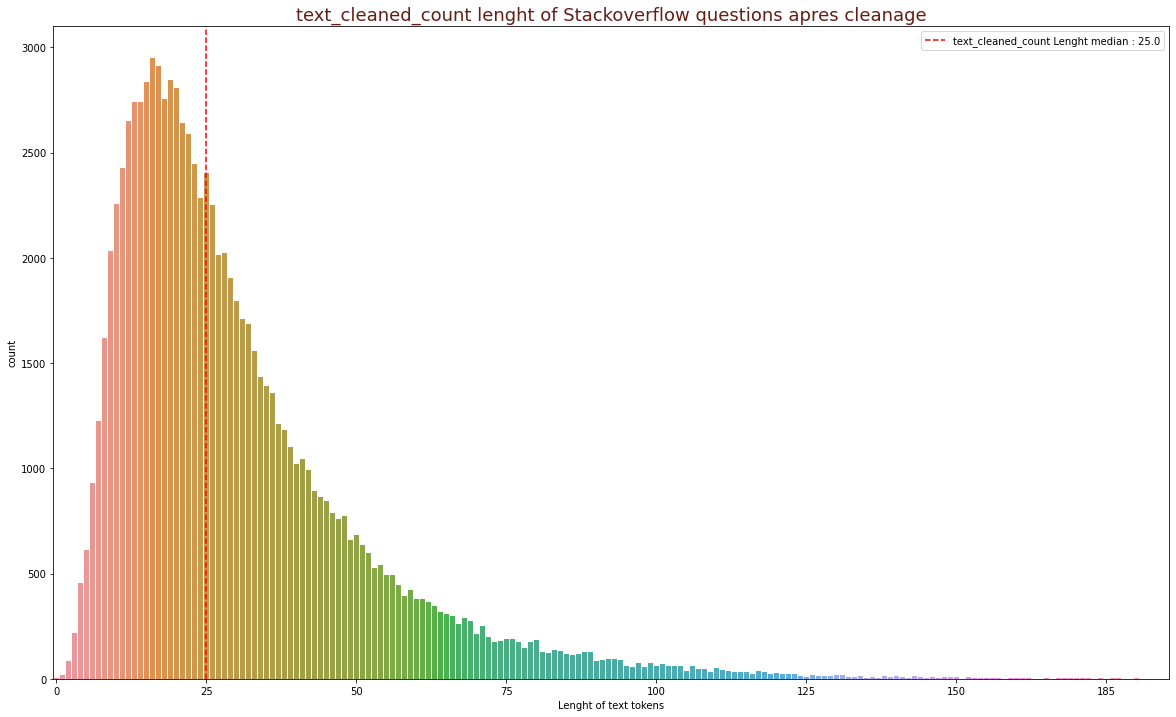

In [85]:
data['text_cleaned_count'] = [len(_) for _ in data.text_cleaned]

# Countplot of body lenght
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=data.text_cleaned_count)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
plot_median = data.text_cleaned_count.median()
plt.axvline(plot_median - data.text_cleaned_count.min(),
            color="r", linestyle='--',
            label="text_cleaned_count Lenght median : "+str(plot_median))
ax.set_xlabel("Lenght of text tokens")
plt.title("text_cleaned_count lenght of Stackoverflow questions apres cleanage",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

**Calcul de la frequences de nos mots dans le corpus**

In [86]:
corpus = []
[corpus.extend(i) for i in data['text_cleaned']]
text_dist = nltk.FreqDist(corpus)
text_dist = pd.DataFrame(text_dist.most_common(2000),columns=['Word', 'Frequency'])

In [87]:
text_dist[text_dist['Word']=='c#']

,Word,Frequency
72,c#,6633


In [88]:
text_dist.describe()

,Frequency
count,2000.000000
mean,1274.748000
std,3180.060666
min,111.000000
25%,181.000000
50%,347.500000
75%,940.000000
max,55650.000000


- Bag of word sur le nouveau corpus 

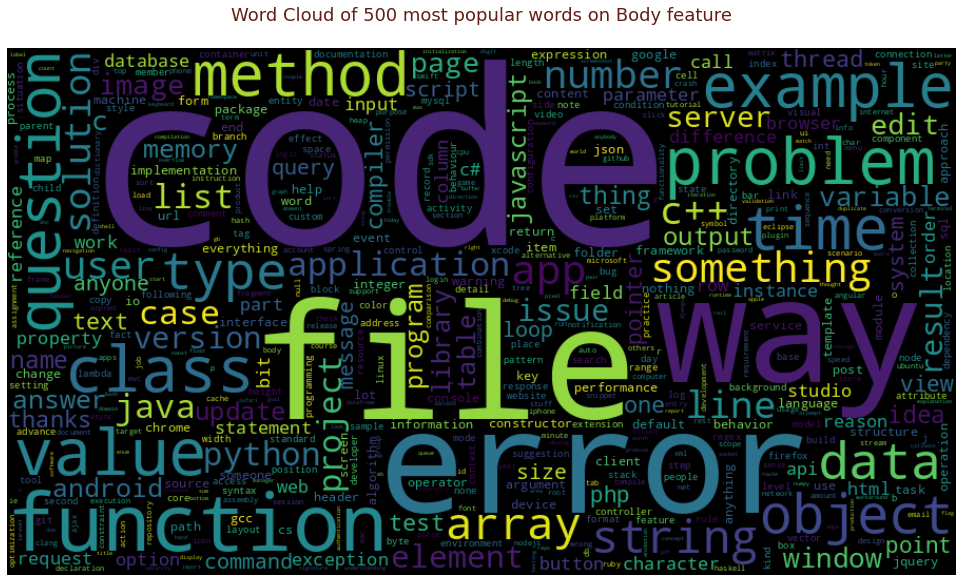

In [89]:
# Plot word cloud with tags_list (frequencies)
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(text_dist.set_index('Word').to_dict()['Frequency'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 most popular words on Body feature\n",
          fontsize=18, color="#641E16")
plt.show()

conservation des questions qui comptent au minimum 5 tokens 

In [90]:
data = data[(data['text_cleaned_count'] >= 5)]

In [91]:
data_cleaned = data[['Tags_list','full_text','text_cleaned','Score']].rename(columns={'Score':'score','text_cleaned': 'text','Tags_list': 'tags'})

In [92]:
data_cleaned.to_csv('stackoverflow_cleaned.csv', sep=";") 